# TAO χpod analysis

## TODO


1. 1023.5 surface does not exist south of 2N? Something is weird. More generally how do I deal with ECCO bias? Or I need to choose bins based on outcrops I guess
1. Argo spline fits are a little steep
1. Estimate gradients at latitude=0, exactly


1. Understand regrid_conservative: Am I providign bin edges or bin centers.
2. Then do the right thing to get derivative.

In [1]:
%aimport cf_xarray
%aimport dcpy
%aimport eddydiff

import eddydiff as ed
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pump

import xarray as xr

xr.set_options(keep_attrs=True)

---
---

## Read χpod , TAO data

In [2]:
chi = (
    xr.open_dataset(
        "~/datasets/chipod/tao/chipods_0_140W.nc",
        decode_cf=False,
        chunks={"time": 10000},
    )
    .set_coords(["mooring", "chipod", "crs"])
    .swap_dims({"timeSeries": "depth"})
    .rename({"Kt": "KT", "Nsqr": "N2"})
    .drop(["timeSeries", "crs"])
)
for var in chi.variables:
    if "FillValue" in chi[var].attrs:
        chi[var].attrs["_FillValue"] = int(chi[var].attrs["FillValue"])
chi = xr.decode_cf(chi)
chi["T"] -= 273
chi.T.attrs["units"] = "C"
chi["KtTz"] = chi.KT * chi.dTdz
chi["lat"] = chi.lat[0].load()
chi["lon"] = chi.lon[0].load()
# TODO: get salinity?
chi["rho"] = dcpy.eos.pden(35, chi.T, 0, pr=0)
chi

<xarray.Dataset>
Dimensions:  (depth: 7, time: 107588)
Coordinates:
  * time     (time) datetime64[ns] 2005-09-23T04:30:00 ... 2017-12-31T23:29:5...
    lat      float64 0.0
    lon      float64 -140.0
  * depth    (depth) float64 29.0 39.0 49.0 59.0 69.0 89.0 119.0
    mooring  float64 9.969e+36
    chipod   float64 9.969e+36
Data variables:
    T        (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    dTdz     (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    N2       (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    KT       (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    chi      (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    eps      (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    Jq       (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    KtTz     (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    rho      (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
Attributes:
    ncei_template_version:           NCEI_NetCDF_TimeSeries_Orthogonal_Templa...
    featureType:                     timeSeries
    title:                           Turbulence quantities measured by chipod...
    summary:                         Turbulence data in upper w m / all good ...
    keywords:                        sea_water_temperature, square_of_brunt_v...
    Conventions:                     CF-1.6, ACDD-1.3
    naming_authority:                edu.oregonstate.coas.mixing
    history:                         2019-07-08 10:19:13 -ncatted
    source:                          fast thermistors FP07
    processing_level:                3: Variables mapped on uniform space-tim...
    comment:                         See reference1 through reference13
    acknowledgment:                  Funding from the National Science Founda...
    license:                         no restrictions
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    date_created:                    2019-07-08T10:19:15415Z
    creator_name:                    Jim Moum / Sally Warner / Aurelie Moulin...
    creator_url:                     http://mixing.coas.oregonstate.edu
    institution:                     Ocean Mixing Group, College of Earth, Oc...
    project:                         TAO, PIRATA
    publisher_name:                  Jim Moum / Sally Warner / Aurelie Moulin...
    publisher_url:                   http://mixing.coas.oregonstate.edu
    geospatial_bounds:               POINT (0 -140)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_min:              0.0
    geospatial_lat_max:              0.0
    geospatial_lon_min:              -140.0
    geospatial_lon_max:              -140.0
    geospatial_vertical_min:         29.0
    geospatial_vertical_max:         119.0
    geospatial_vertical_positive:    down
    time_coverage_start:             2005-09-23T04:30:00000Z
    time_coverage_end:               2017-12-31T23:30:00000Z
    time_coverage_duration:          P12Y3M7DT19H0M00S
    time_coverage_resolution:        PT1H
    sea_name:                        Equatorial Pacific Ocean
    creator_type:                    group
    creator_institution:             College of Earth, Ocean, and Atmospheric...
    publisher_type:                  group
    publisher_institution:           College of Earth, Ocean, and Atmospheric...
    contributor_name:                Jim Moum, Sally Warner, Sasha Perlin, Au...
    contributor_role:                Processed and/or archived data
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_west
    geospatial_vertical_units:       m
    date_modified:                   2019-07-08T10:19:27096Z
    date_issued:                     2019-07-08T10:19:27416Z
    date_metad

In [3]:
tao = xr.open_mfdataset(
    "/home/deepak/datasets/TaoTritonPirataRama/TAO_TRITON/[ts]_xyzt_dy.cdf",
    chunks={"depth": 10, "time": 8000},
)

for var in ["T_20", "S_41"]:
    tao[var].attrs["missing_value"] = tao.attrs["missing_value"]
    tao[var].attrs["_FillValue"] = tao.attrs["_FillValue"]
tao = xr.decode_cf(tao).rename({"T_20": "T", "S_41": "S"})
tao = tao.assign_coords(lon=tao.lon - 360)
tao = tao[["S", "T"]]
tao

<xarray.Dataset>
Dimensions:  (depth: 71, lat: 11, lon: 12, time: 14983)
Coordinates:
  * lat      (lat) float32 -8.0 -5.0 -2.0 0.0 2.0 3.5 5.0 8.0 9.0 10.0 12.0
  * depth    (depth) float64 1.0 1.5 2.0 3.0 5.0 ... 450.0 470.0 500.0 750.0
  * time     (time) datetime64[ns] 1977-01-01T12:00:00 ... 2018-01-08T12:00:00
  * lon      (lon) float32 -230.0 -223.0 -213.0 -204.0 ... -125.0 -110.0 -95.0
Data variables:
    S        (lon, lat, depth, time) float32 dask.array<chunksize=(12, 11, 15, 11652), meta=np.ndarray>
    T        (lon, lat, depth, time) float32 dask.array<chunksize=(12, 11, 12, 8000), meta=np.ndarray>
Attributes:
    array:                        TAO/TRITON
    Data_Source:                  GTMBA Project Office/NOAA/PMEL
    Data_info:                    Contact Paul Freitag: 206-526-6727
    File_info:                    Contact Dai McClurg: Dai.C.McClurg@noaa.gov
    Request_for_acknowledgement:  If you use these data in publications or pr...
    missing_value:                1e+35
    _FillValue:                   1e+35

In [4]:
chisub = chi.sel(time=slice("2008-05-01", "2009-05-01"))

In [32]:
obj = tao
other = chisub


def sel_like(obj, other):
    common_dims = set(obj.dims) & set(other.dims)
    return {dim: slice(other[dim][0].data, other[dim][-1].data) for dim in common_dims}


sel_like(tao, chisub)

{'depth': slice(array(29.), array(119.), None),
 'time': slice(array('2008-05-01T00:30:00.000003328', dtype='datetime64[ns]'), array('2009-05-01T23:29:59.999996672', dtype='datetime64[ns]'), None)}

In [5]:
def calc_mld(pden):

    drho = pden - pden.cf.isel(Z=0)
    return xr.where(drho > 0.015, np.abs(drho.cf["Z"]), np.nan).cf.min("Z")

In [6]:
def subset_mooring_to_chipod(tao, chipod):
    taos = (
        tao.sel(lat=chipod.lat.load().item(), lon=chipod.lon.load().item(), method="nearest",)
        .sel(
            time=slice(chipod.time[0], chipod.time[-1]),
            depth=slice(chipod.depth.max().item() - 20),
        )
        .load()
        .dropna("depth", how="all")
        .dropna("time", how="all")
        # .interpolate_na("depth")
        .interpolate_na("time", max_gap="2D")
    )
    
    taos["rho"] = dcpy.eos.pden(taos.S.interpolate_na("depth"), taos.T, 0, pr=0)
    taos["rhoT"] = dcpy.eos.pden(35, taos.T, 0, pr=0)
    taos["rho"].attrs.update({"long_name": "$ρ$", "units": "kg/m³"})
    taos["rhoT"].attrs.update({"long_name": "$ρ^T$", "units": "kg/m³"})
    taos["mld"] = calc_mld(taos.rhoT)
    
    return taos

taos = subset_mooring_to_chipod(tao, chisub)
taos

<xarray.Dataset>
Dimensions:  (depth: 13, time: 357)
Coordinates:
    lon      float32 -140.0
    lat      float32 0.0
  * depth    (depth) float64 1.0 5.0 10.0 13.0 20.0 ... 45.0 48.0 60.0 80.0 83.0
  * time     (time) datetime64[ns] 2008-05-10T12:00:00 ... 2009-05-01T12:00:00
Data variables:
    S        (depth, time) float32 nan 35.24 35.265 35.281 ... nan nan nan nan
    T        (depth, time) float32 25.88 25.94 26.06 26.18 ... 24.16 23.43 23.86
    rho      (depth, time) float32 nan 1023.23315 1023.2145 ... nan nan nan
    rhoT     (depth, time) float32 1023.0707 1023.05206 ... 1023.80896 1023.6828
    mld      (time) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Attributes:
    array:                        TAO/TRITON
    Data_Source:                  GTMBA Project Office/NOAA/PMEL
    Data_info:                    Contact Paul Freitag: 206-526-6727
    File_info:                    Contact Dai McClurg: Dai.C.McClurg@noaa.gov
    Request_for_acknowledgement:  If you use these data in publications or pr...
    missing_value:                1e+35
    _FillValue:                   1e+35

Mask out mixed layer depth...

In [7]:
chisub = chisub.where(chisub.depth > taos.mld.interp(time=chisub.time))

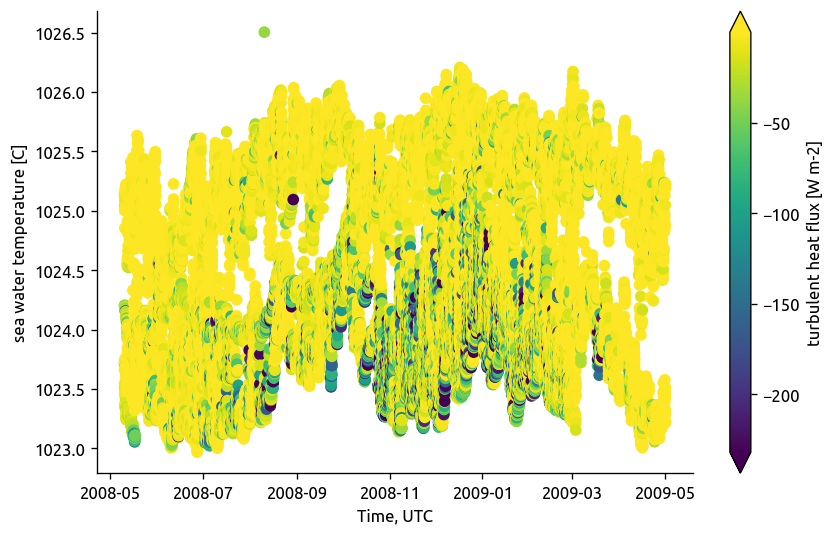

In [36]:
# chi to density space
chisub.plot.scatter(x="time", y="rho", hue="Jq", robust=True)

---

## Read in gradients

### argo

In [8]:
argograd = xr.open_zarr(
    "../datasets/argo_monthly_iso_gradients.zarr", decode_times=False
)
argograd = argograd.cf.guess_coord_axis()
argograd.pres.attrs["positive"] = "down"
argograd = argograd.cf.add_bounds("pres")
argo = (
    argograd.sel(lon=360 + chisub.lon.item(), method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(500))
    .mean("time")
)
argo["pden"] = ed.jmd95.dens(
    argo.Smean, argo.Tmean, 0 #ecco.pres.broadcast_like(ecco.Smean)
)
argo

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 11, pres: 34)
Coordinates:
  * lat          (lat) float32 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5
    lon          float32 220.5
  * pres         (pres) float64 2.5 10.0 20.0 30.0 ... 420.0 440.0 462.5 500.0
    pres_bounds  (bounds, pres) float32 -1.25 6.25 15.0 ... 450.0 473.75 518.75
Dimensions without coordinates: bounds
Data variables:
    Smean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    Tmean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSdia        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSdz         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSiso        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTdia        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTdz         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTiso        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    ρmean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    pden         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
Attributes:
    dataset:  argo
    name:     Mean fields and isopycnal, diapycnal gradients from Argo

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:958: UserWarning: Variables {'pres_bounds'} not found in object but are referred to in the CF attributes.
  UserWarning,


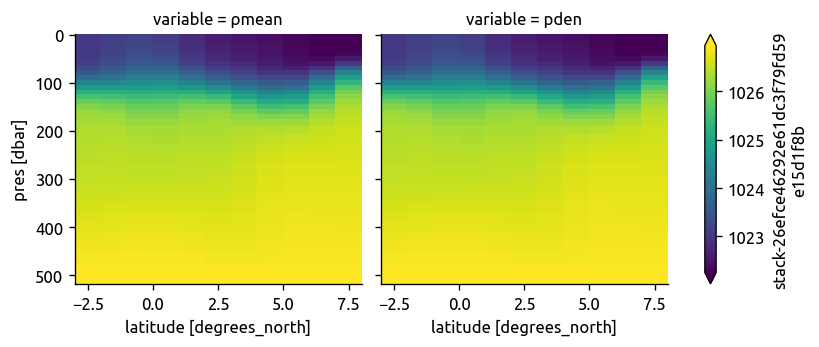

In [38]:
(
    argo[["ρmean", "pden"]]
    # .sel(lon=220, method="nearest")
    .to_array().cf.plot(col="variable", y="vertical", robust=True)
)

---
### ECCO

In [9]:
eccograd = xr.open_zarr(
    "../datasets/ecco_monthly_iso_gradients.zarr", decode_times=False
)
eccograd = eccograd.cf.guess_coord_axis()
eccograd.pres.attrs["positive"] = "down"
eccograd = eccograd.cf.add_bounds("pres")

ecco = (
    eccograd.sel(lon=360 + chisub.lon.item(), method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(500))
    .mean("time")
)
ecco["pden"] = ed.jmd95.dens(
    ecco.Smean, ecco.Tmean, 0 #ecco.pres.broadcast_like(ecco.Smean)
)

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:958: UserWarning: Variables {'pres_bounds'} not found in object but are referred to in the CF attributes.
  UserWarning,


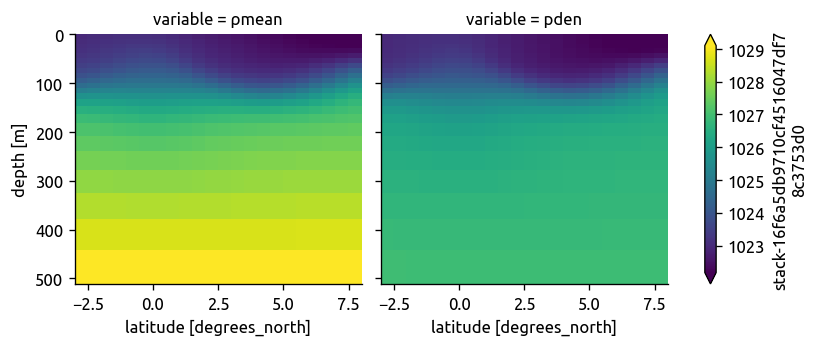

In [42]:
(
    ecco[["ρmean", "pden"]]
    # .sel(lon=220, method="nearest")
    .to_array().cf.plot(col="variable", y="vertical", robust=True)
)

In [43]:
subset.Tmean.cf.plot(ylim=(200, 0), robust=True)
subset.ρmean.cf.plot.contour(levels=11, colors="k", ylim=(200, 0), robust=True)
subset.pden.cf.plot.contour(levels=11, colors="r")
# eccograd.ρmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
#     lon=220, lat=0, method="nearest"
# ).plot.contour(levels=11, x="time", ylim=(200, 0), robust=True)

NameError: name 'subset' is not defined

# ---
---

## Evaluate bin choices


1. How well do ECCO & Argo agree?
1. Do the chosen ρ levels cross the mooring location? Otherwise I can't get an estimate of lateral gradient? I need the edges to cross too, so that I can get a vertical gradient
1. How do the bins look in T-S space? Am I seeing enough stirring to do the analysis

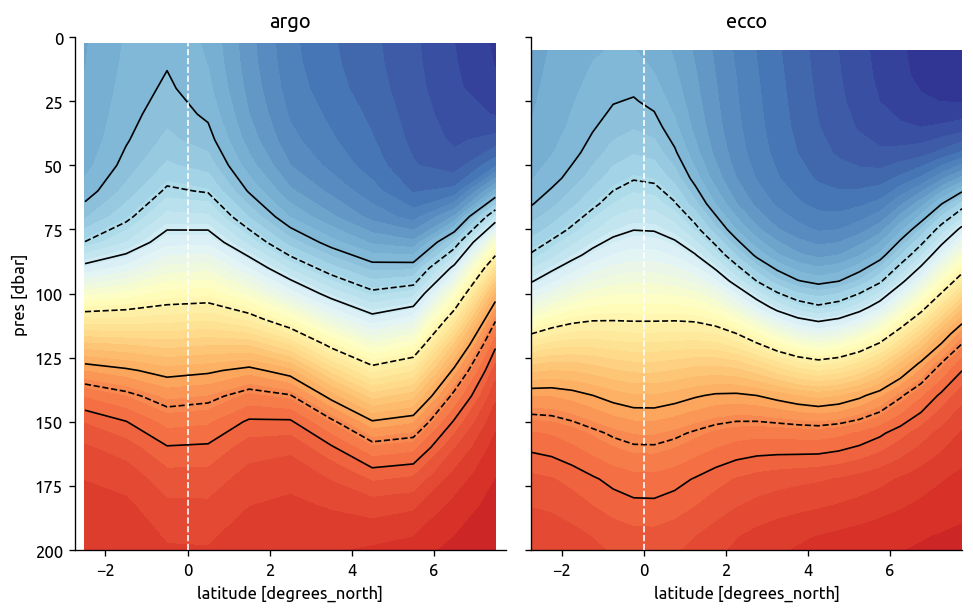

In [253]:
bins = [
    1022.5,
    1023,
    1023.5,
    1024,
    1024.5,
    1025,
    1025.5,
    1026,
    1026.5,
]
bins = np.array([1023.2, 1023.85, 1025.5, 1026])
centers = (bins[1:] + bins[:-1]) / 2


def debug_bins(bins):
    centers = (bins[1:] + bins[:-1]) / 2

    f, axx = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)

    for ds, ax in zip([argo, ecco], axx):
        ds.pden.cf.plot.contourf(
            y="Z",
            ax=ax,
            levels=np.arange(1022, 1027, 0.1),
            cmap=mpl.cm.RdYlBu_r,
            add_colorbar=False,
            ylim=(200, 0),
        )
        ds.pden.cf.plot.contour(y="Z", colors="k", levels=bins, ax=ax)
        ds.pden.cf.plot.contour(
            y="Z", colors="k", linestyles="--", levels=centers, ax=ax
        )
        dcpy.plots.linex(0, zorder=10, color="w", ax=ax)
        ax.set_title(ds.dataset)

    dcpy.plots.clean_axes(axx)


debug_bins(bins)

({'ts': <matplotlib.collections.PathCollection at 0x7f128a6450d0>,
  'rho_contours': <matplotlib.contour.QuadContourSet at 0x7f128a645650>,
  'Thist': (array([0.00199008, 0.00398013, 0.00597024, 0.00597024, 0.0099504 ,
          0.0119404 , 0.03383136, 0.03383136, 0.04975168, 0.04776192,
          0.04577184, 0.05970202, 0.03781152, 0.09751392, 0.07960269,
          0.11144448, 0.1393056 , 0.14129568, 0.21890739, 0.27662112,
          0.27264096, 0.33831142, 0.25672032, 0.1890576 , 0.17313696,
          0.25074847, 0.32040287, 0.11343456, 0.02587087, 0.0099504 ]),
   array([18.37    , 18.667334, 18.964668, 19.262001, 19.559334, 19.856667,
          20.154001, 20.451334, 20.748667, 21.046001, 21.343334, 21.640667,
          21.938002, 22.235334, 22.532667, 22.830002, 23.127335, 23.424667,
          23.722   , 24.019335, 24.316668, 24.614   , 24.911335, 25.208668,
          25.506   , 25.803333, 26.100668, 26.398   , 26.695333, 26.992668,
          27.29    ], dtype=float32),
   <a list 

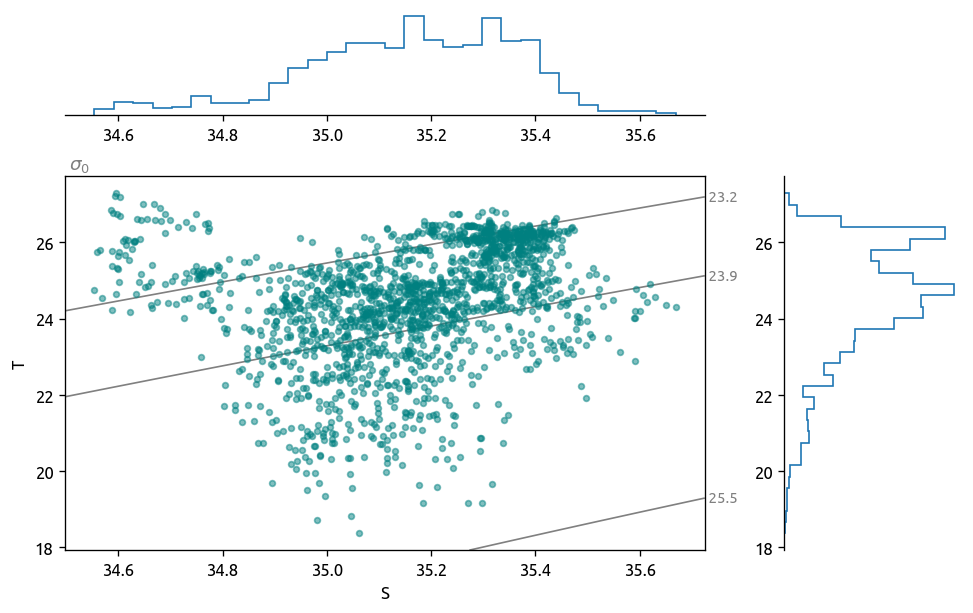

In [255]:
dcpy.oceans.TSplot(
    taos.S, taos.T, rho_levels=bins, hexbin=False,
)

---

## Estimate gradients

The magnitudes of ∂T/∂y seem to agree to within a factor of 2. Though the latitudinal profile of these gradients looks quite different (argo vs ecco)

The spline fits to the Argo data seems a little "stiff". Maybe I need to play with some parameters

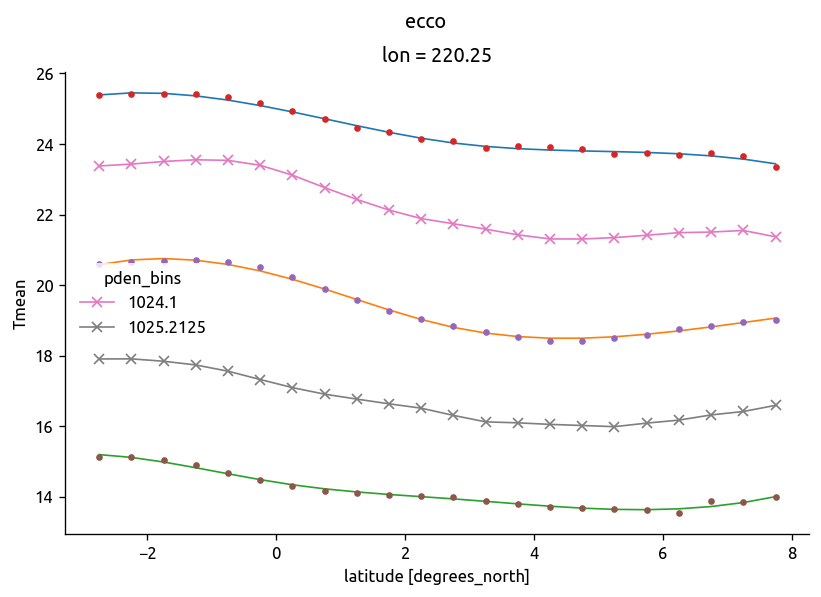

In [254]:
# bins = np.arange(1023, 1029, 0.5)

def estimate_gradients(grad, bins, debug=False):
    """
    Estimates the isopycnal and vertical gradients of temperature
    
    Parameters
    ----------
    
    grad: Dataset
        Climatological fields with temperature
    bins: np.array
        Isopycnal bin edges
    
    Returns
    -------
    
    Dataset with ``dTdy`` and ``dTdz``
    
    Notes
    -----
    
    Procedure:
      - First conservatively regrids T to isopycnal space using bin averages
      - Then fits univariate spline to mean T in each isopycnal bin
      - Estimates ∂T/∂y using this spline fit.
      - ∂T/∂z is estimated using the mean separation between isopycnal bin edges
        (product of the isopycnal regridding code)
    """
    bins = np.asarray(bins)

    isoT = ed.regrid_to_isopycnals(grad, bins)

    # get isopycnal gradients of T by fitting spline
    # to average T in density bins
    isoT.coords["y"] = dcpy.util.latlon_to_distance(
        isoT.cf["latitude"], isoT.cf["longitude"], 0, isoT.lon.item()
    ) * np.sign(isoT.lat)
    isoT.y.attrs["axis"] = "Y"

    sub = isoT.Tmean.chunk({"lat": -1}).swap_dims({"lat": "y"})
    spinterp = dcpy.interpolate.UnivariateSpline(sub, "y")
    isoT["dTdy"] = spinterp.derivative(sub.y).swap_dims({"y": "lat"})

    if debug:
        plt.figure()
        spinterp.smooth().plot.line(x="lat", hue="pden_bins", add_legend=False)
        sub.plot.line(x="lat", hue="pden_bins", marker=".", ls="none", add_legend=True)
        plt.suptitle(grad.attrs["dataset"])

    # regrid to the bin edges. This is a little roundabout
    centers = (bins[1:] + bins[:-1]) / 2
    edge = (
        ed.regrid_to_isopycnals(grad, centers)
        .load()
        #.assign_coords(pden_bins=centers[:-1])
        #.reindex_like(isoT, method="nearest")
        #.assign_coords(pden_bins=centers)
    )
    isoT["dTdz"] = (-1 * isoT.Tmean.diff("pden_bins") / edge.dz_remapped)
    if debug:
        edge.Tmean.plot.line(marker="x", hue="pden_bins")

    return isoT, edge


eccoT, edge = estimate_gradients(ecco, bins, debug=True)
# argoT = estimate_gradients(argo, bins, debug=True)

In [197]:
eccoT.dTdz.sel(lat=0, method="nearest").compute()

/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)


<xarray.DataArray 'dTdz' (pden_bins: 4)>
array([       nan,        nan, 0.10839718, 0.12197023])
Coordinates:
  * pden_bins    (pden_bins) float64 1.023e+03 1.024e+03 1.025e+03 1.026e+03
    lat          float64 0.25
    lon          float64 220.2
    dz_remapped  (pden_bins) float64 nan 54.03 61.63 35.28
    y            float64 2.783e+04

### Horizontal gradient

/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)
/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)
/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)
/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)


<Figure size 960x600 with 0 Axes>

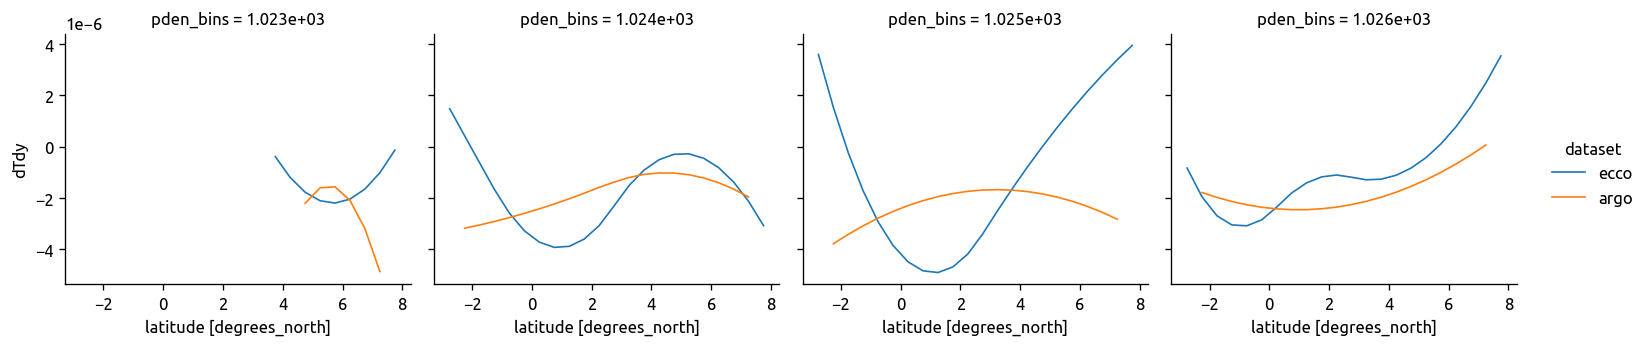

In [14]:
plt.figure()
xr.concat([eccoT.dTdy, argoT.dTdy.interp(lat=eccoT.lat)], dim=["ecco", "argo"]).rename(
    {"concat_dim": "dataset"}
).plot.line(x="lat", col="pden_bins", hue="dataset")

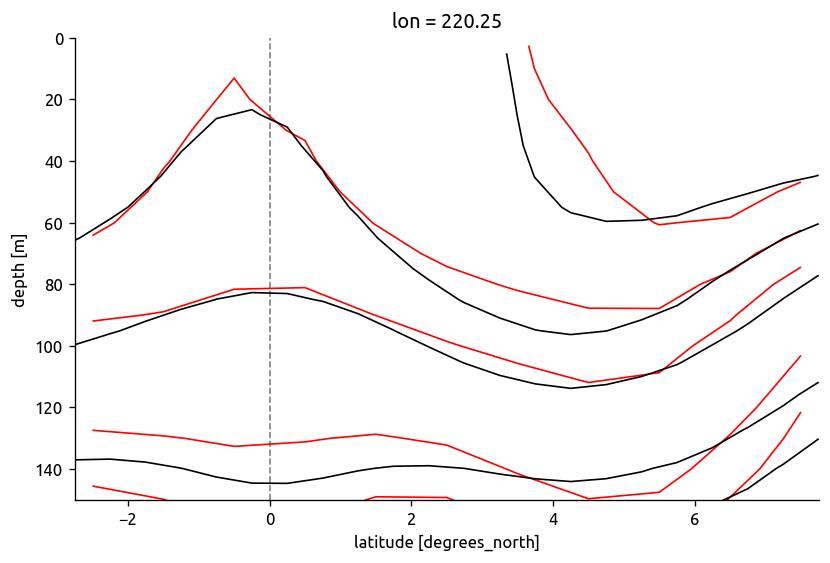

In [61]:
plt.figure()
argo.pden.plot.contour(levels=bins, colors="r")
ecco.pden.plot.contour(levels=bins, colors="k", ylim=(150, 0))
plt.legend(["argo", "ecco"])
dcpy.plots.linex(0)

### debugging plots

/home/deepak/work/eddydiff/eddydiff/regrid.py:137: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)


(<scipy.interpolate.fitpack2.UnivariateSpline at 0x7ff755aaca50>,
 array([21.90429497, 21.72667968, 21.55734077, 21.39696077, 21.24622219,
        21.10580757, 20.97639942, 20.85868027, 20.75333265, 20.66103907,
        20.58248207, 20.51749616, 20.46252382, 20.41315952, 20.36499774,
        20.31363294, 20.25465961, 20.18367222, 20.09626523, 19.98803313,
        19.85457038, 19.69354891, 19.51095047, 19.31483424, 19.11325943,
        18.91428523, 18.72597083, 18.55637544, 18.41355825, 18.30557845,
        18.24049523, 18.22210838, 18.23717995, 18.26821257, 18.29770888,
        18.30817152, 18.28210313, 18.20200633, 18.05038376, 17.80973806]))

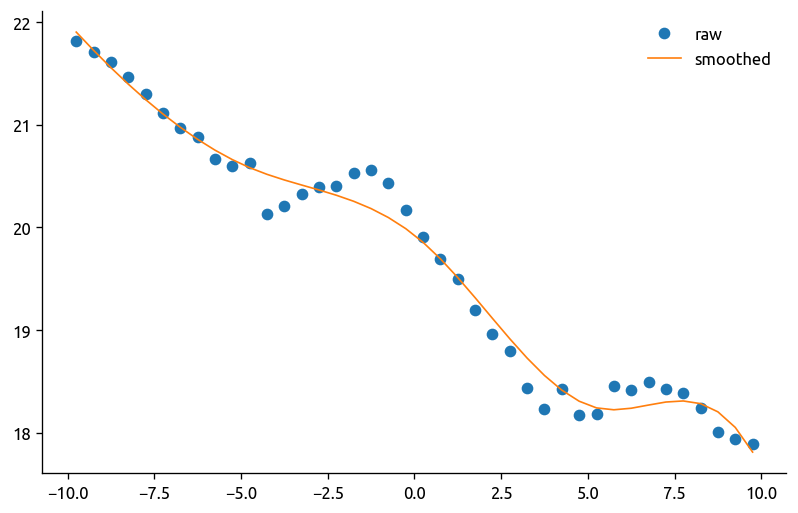

In [126]:
ed.fit_spline(isoT.lat, isoT.Tmean.isel(ρmean_bins=10).values, debug=True)

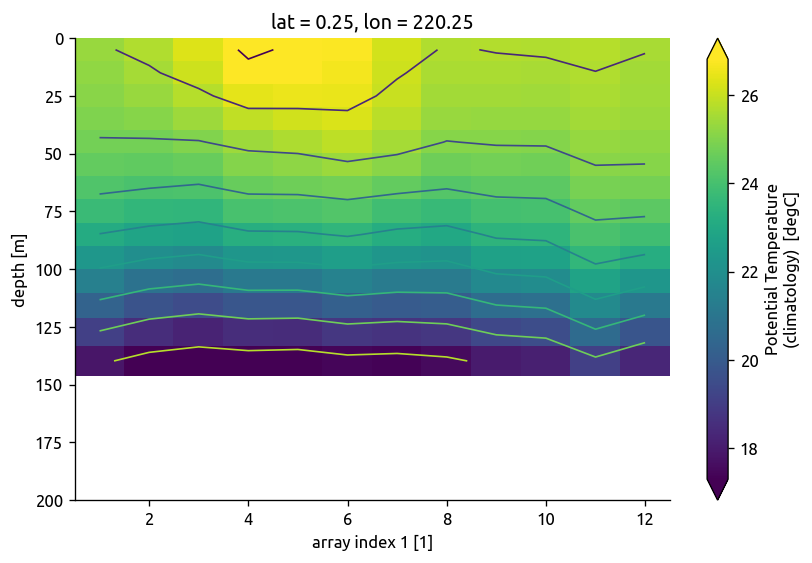

In [4]:
eccograd.Tmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
    lon=220, lat=0, method="nearest"
).plot(x="time", ylim=(200, 0), robust=True)
eccograd.ρmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
    lon=220, lat=0, method="nearest"
).plot.contour(levels=11, x="time", ylim=(200, 0), robust=True)

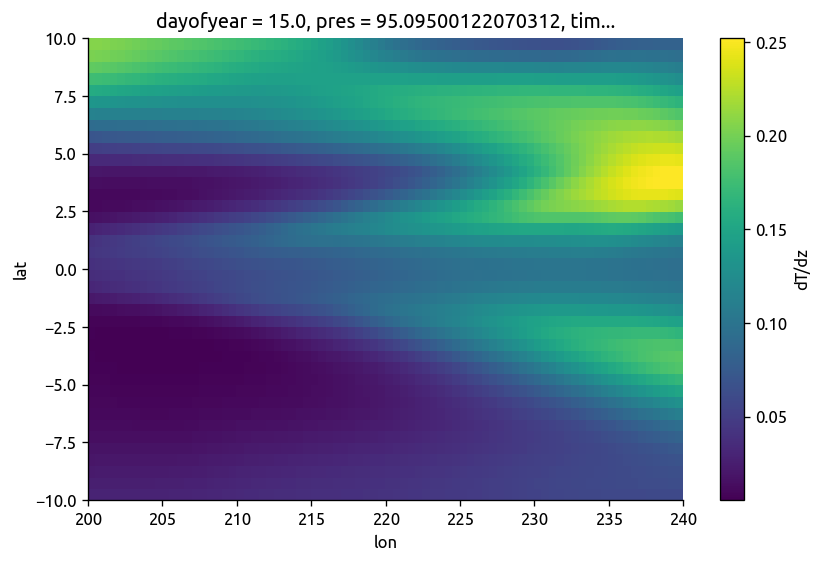

In [58]:
eccograd.dTdz.sel(lat=slice(-10, 10), lon=slice(200, 240)).sel(
    pres=100, method="nearest"
).isel(time=0).plot()

/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8711 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8711 missing from current font.
  font.set_text(s, 0, flags=flags)


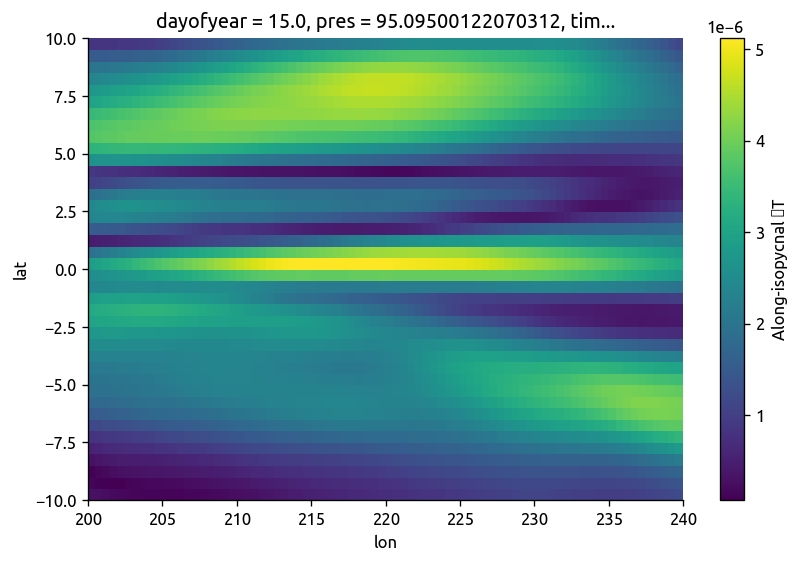

In [55]:
eccograd.dTiso.sel(lat=slice(-10, 10), lon=slice(200, 240)).sel(
    pres=100, method="nearest"
).isel(time=0).plot()

/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)


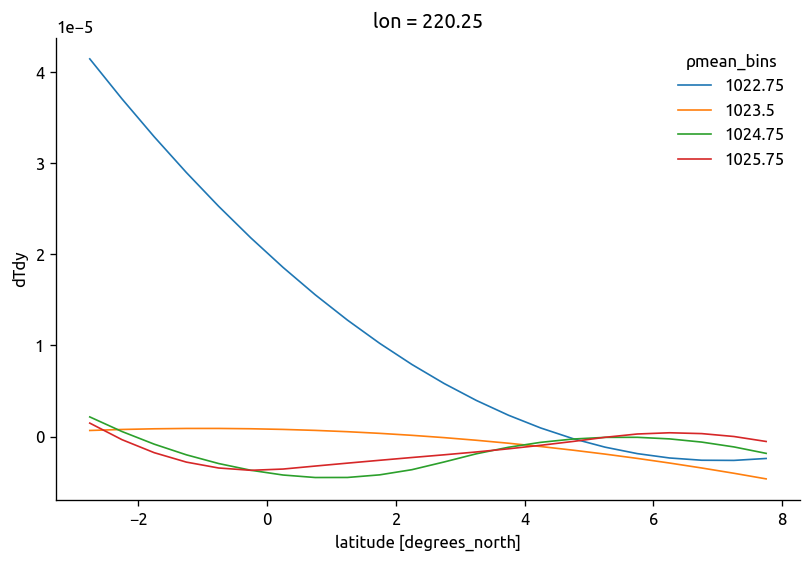

In [206]:
isoT.dTdy.plot.line(hue="ρmean_bins")

---
---

### Vertical gradient


In [169]:
argoT.dTdz.sel(lat=0, method="nearest")

AttributeError: 'tuple' object has no attribute 'dTdz'

/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)
/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)


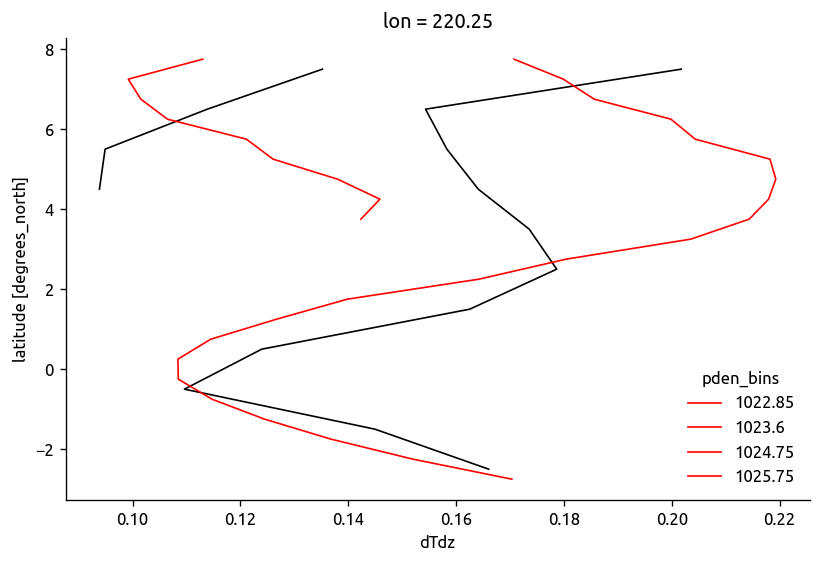

In [171]:
argoT.dTdz.plot.line(y="lat", color="k")
eccoT.dTdz.plot.line(y="lat", color="r")

---
---

## Do estimate

In [86]:
chidf = chisub.to_dataframe().dropna()
chidf.KT.groupby(pd.cut(chidf.rho, bins)).count()

rho
(1022.5, 1023.2]      856
(1023.2, 1024.0]    16902
(1024.0, 1025.5]    16244
(1025.5, 1026.0]     3025
Name: KT, dtype: int64

In [121]:
# TODO: move this to ed.bin_to_density_space
def bin_avg_in_density_time(input, ρbins, strftime="%Y-%m"):
    """
        Takes input dataframe for transect, bins each profile by density
        and averages. Returns average data as function of transect distance,
        mean density in bin.

    """
    
    input = input.reset_index()
    time_grouper = input.time.dt.strftime(strftime)

    result = (
        input
        .groupby([pd.cut(input.rho, ρbins), time_grouper])
        .mean()
        .dropna(how="any")
        .drop("rho", axis=1)
        .reset_index()
        # .to_xarray()
    )
    result["time"] = pd.to_datetime(result["time"])
    
    return result.set_index(["rho", "time"])


binned = bin_avg_in_density_time(chidf, bins).drop(
    ["timeSeries", "lat", "lon", "mooring", "chipod", "crs"], axis=1, errors="ignore",
)
rhotime = binned.index.to_frame()
midpoints = pd.Series([v.mid for v in rhotime["rho"].values], name="rho")
newindex = pd.MultiIndex.from_arrays([midpoints, rhotime["time"]])
float_indexed = binned.set_index(newindex)
chidens = xr.Dataset.from_dataframe(float_indexed)
chidens = chidens.rename({"rho": "pden_bins"})
chidens

<xarray.Dataset>
Dimensions:    (pden_bins: 4, time: 13)
Coordinates:
  * pden_bins  (pden_bins) float64 1.023e+03 1.024e+03 1.025e+03 1.026e+03
  * time       (time) datetime64[ns] 2008-05-01 2008-06-01 ... 2009-05-01
Data variables:
    depth      (pden_bins, time) float64 39.0 69.0 69.0 nan ... 119.0 119.0 nan
    T          (pden_bins, time) float64 25.68 25.72 25.68 ... 16.45 16.49 nan
    dTdz       (pden_bins, time) float64 0.02539 0.04847 0.05484 ... 0.1086 nan
    N2         (pden_bins, time) float64 7.343e-05 0.0001311 ... 0.0002419 nan
    KT         (pden_bins, time) float64 0.0006447 7.341e-05 ... 1.621e-05 nan
    chi        (pden_bins, time) float64 5.508e-07 2.519e-07 ... 2.105e-08 nan
    eps        (pden_bins, time) float64 1.96e-07 4.185e-08 ... 2.651e-09 nan
    Jq         (pden_bins, time) float64 -51.45 -11.33 -30.65 ... -0.9572 nan
    KtTz       (pden_bins, time) float64 1.425e-05 3.6e-06 ... 1.618e-06 nan

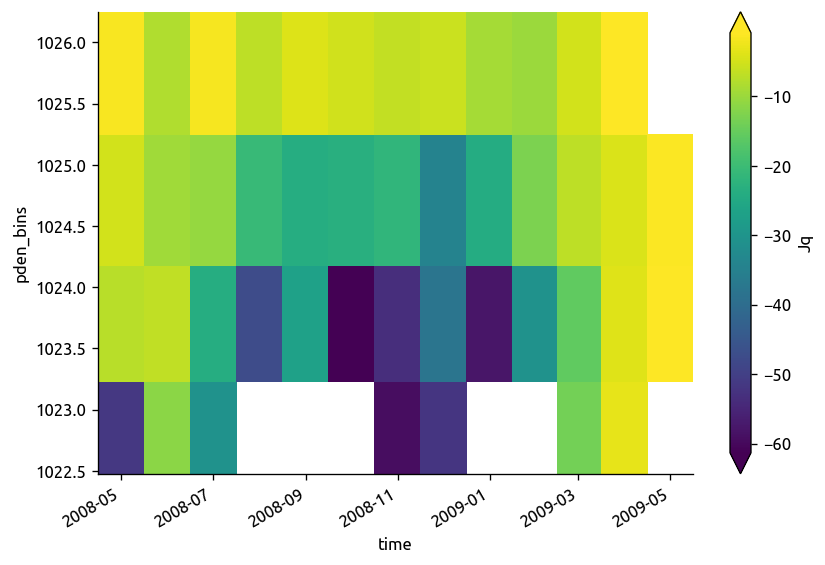

In [122]:
hdl = chidens.Jq.plot(robust=True)

In [132]:
(chidens["KtTz"])

<xarray.DataArray 'KtTz' (pden_bins: 4, time: 13)>
array([[1.42461080e-05, 3.60002989e-06, 8.81038040e-06,            nan,
                   nan,            nan, 4.22777627e-05, 1.63298156e-05,
                   nan,            nan, 1.12507623e-05, 1.31023104e-06,
                   nan],
       [7.17465397e-06, 5.10019242e-06, 9.31246899e-06, 1.97345794e-05,
        1.04158602e-05, 2.85112834e-05, 2.34413050e-05, 2.40860968e-05,
        2.79323052e-05, 1.54515695e-05, 7.20784783e-06, 2.52236061e-06,
        4.14527700e-07],
       [1.48744077e-05, 2.63598927e-05, 3.22508634e-05, 2.32581234e-05,
        1.74978310e-05, 2.76089056e-05, 1.93776298e-05, 1.50068943e-05,
        1.89452197e-05, 3.30859029e-05, 3.65652324e-05, 5.95147007e-05,
        1.43220384e-05],
       [5.74216946e-07, 1.66676200e-04, 1.14326637e-05, 5.43181750e-05,
        3.76439593e-05, 1.95715744e-05, 7.09051684e-05, 4.10507868e-05,
        8.21672608e-05, 1.34350334e-04, 3.24650666e-05, 1.61778263e-06,
                   nan]])
Coordinates:
  * pden_bins  (pden_bins) float64 1.023e+03 1.024e+03 1.025e+03 1.026e+03
  * time       (time) datetime64[ns] 2008-05-01 2008-06-01 ... 2009-05-01

In [126]:
isoT = argoT.sel(lat=0, method="nearest")
Ke = (chidens["chi"] / 2 - np.abs(chidens["KtTz"] * isoT["dTdz"])) / (isoT["dTdy"] ** 2)
Ke.compute()a

/home/deepak/work/eddydiff/eddydiff/regrid.py:136: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return _interp_1d_conservative(phi, theta_1, theta_2, theta_hat_1, theta_hat_2)


<xarray.DataArray (pden_bins: 4, time: 13)>
array([[              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan],
       [              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan],
       [ -387179.42288466,  -680917.23380501,  -829369.40849118,
         -569280.95408438,  -385552.983219  ,  -680720.081195  ,
         -409853.44906593,  -258620.69050264,  -428443.44652516,
         -829203.50230201,  -948493.30000457, -1568691.8259746 ,
         -376813.34549031],
       [              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan]])
Coordinates:
  * pden_bins    (pden_bins) float64 1.023e+03 1.024e+03 1.025e+03 1.026e+03
  * time         (time) datetime64[ns] 2008-05-01 2008-06-01 ... 2009-05-01
    lat          float32 0.5
    lon          float32 220.5
    dz_remapped  (pden_bins) float64 nan 47.76 50.09 27.43
    y            float64 5.566e+04

---
---

## Old stuff

In [ ]:
eccograd, argograd, cole, aber = ed.read_all_datasets(kind="monthly")

In [157]:
argograd.time.attrs["axis"] = "T"
argograd.pres.attrs["positive"] = "down"

NameError: name 'argograd' is not defined

In [73]:
argograd.sel(lat=0, lon=360 - 140, method="nearest").dTiso.cf.plot.pcolormesh(
    y="Z", robust=True, cmap=mpl.cm.Oranges
)

TypeError: descriptor '_key' for 'ExplicitIndexer' objects doesn't apply to 'BasicIndexer' object

In [26]:
chidens = binned.to_xarray()

In [27]:
grad, _ = ed.bin_to_density_space(
    argograd.sel(lat=0, lon=360 - 140, method="nearest").rename({"ρmean": "rho"}),
    bins=bins,
)
grad = grad.sel(time=chidens.time.dt.month.values).assign_coords(time=chidens.time)
grad

<xarray.Dataset>
Dimensions:   (rho: 4, time: 358)
Coordinates:
  * time      (time) datetime64[ns] 2008-05-10 2008-05-11 ... 2009-05-02
  * rho       (rho) float32 1022.75 1023.25 1024.5 1025.75
    lat       float32 0.5
    lon       float32 220.5
Data variables:
    pres      (time, rho) float64 15.62 50.0 95.0 140.0 ... 50.0 95.0 140.0
    Smean     (time, rho) float32 35.150955 35.16125 ... 35.08096 34.97392
    Tmean     (time, rho) float32 26.652958 25.90761 ... 21.142931 15.874863
    dSdia     (time, rho) float64 0.0004355 0.0007541 ... 0.002183 0.002707
    dSdz      (time, rho) float32 -0.00043551126 0.0005791346 ... 0.002706909
    dSiso     (time, rho) float64 1.038e-06 1.437e-06 ... 2.434e-06 1.457e-06
    dTdia     (time, rho) float64 0.009585 0.0497 0.127 ... 0.0497 0.127 0.08775
    dTdz      (time, rho) float32 0.009585428 0.04970134 ... 0.08775275
    dTiso     (time, rho) float64 2.479e-06 3.539e-06 ... 6.849e-06 5.099e-06
    mean_rho  (time, rho) float32 1022.9419 1023.1831 ... 1024.4943 1025.7537

In [28]:
chidens["rho"] = grad["rho"]

In [68]:
Ke = (chidens["chi"] / 2 - np.abs(chidens["KtTz"] * grad["dTdz"] / 3)) / (
    grad["dTiso"] ** 2
)
Ke

<xarray.DataArray (rho: 4, time: 358)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 11726.46725949,   8248.95985651,   5027.56820076, ...,
          -204.25370459,   -334.24473111,   -187.44859464],
       [ -1879.12790238, -12763.75317847, -15621.72404617, ...,
        -40449.6307827 , -59050.73202118, -58244.54230018],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * rho      (rho) float32 1022.75 1023.25 1024.5 1025.75
  * time     (time) datetime64[ns] 2008-05-10 2008-05-11 ... 2009-05-02
    lat      float32 0.5
    lon      float32 220.5

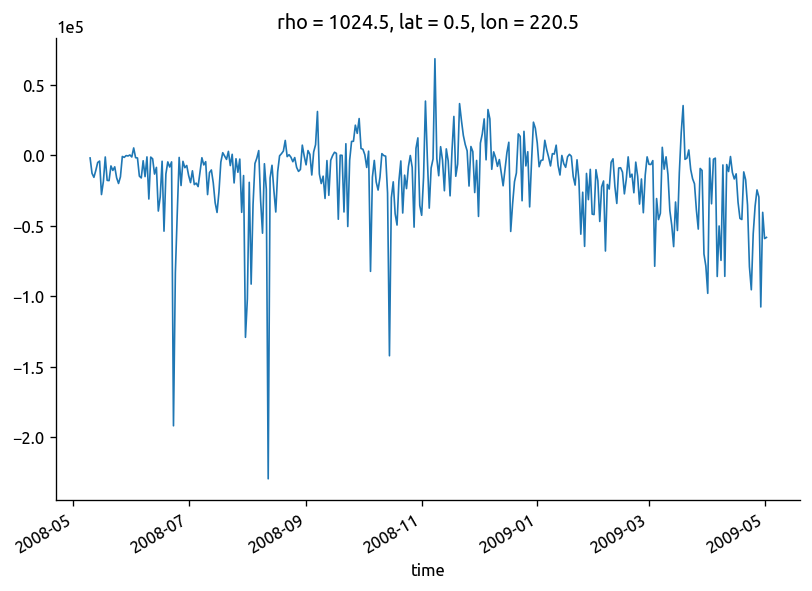

In [69]:
Ke.isel(rho=2).plot()

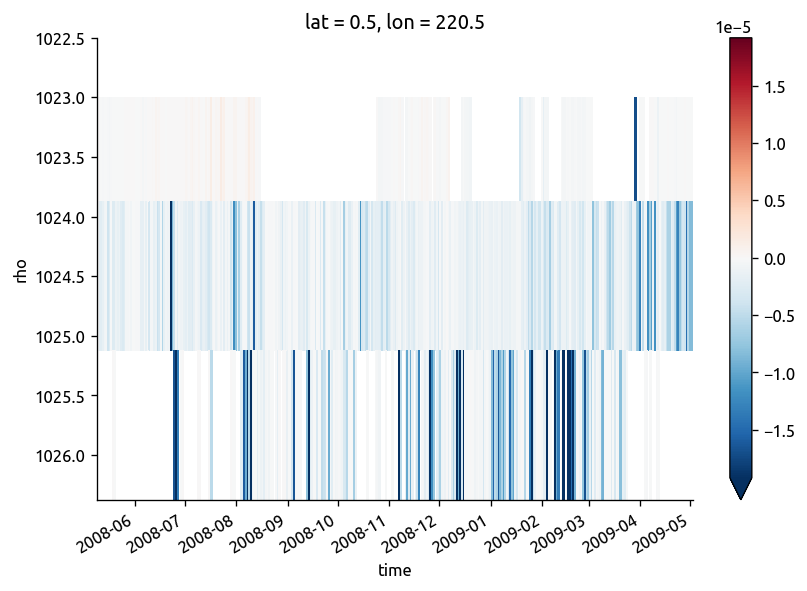

In [42]:
(chidens["chi"] / 2 - np.abs(chidens["KtTz"] * grad["dTdz"])).cf.plot(
    x="time", y="rho", robust=True
)